### Util

In [1]:
import pandas as pd
import numpy as np
from scipy import interp
#import matplotlib.pyplot as plt
import os

from IPython.display import Image
import pydotplus
import graphviz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from catboost import CatBoostClassifier, Pool


from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split,cross_val_score,cross_validate
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, roc_auc_score,roc_curve, auc, brier_score_loss
from sklearn import tree
import xgboost as xgb
from xgboost import XGBClassifier
from itertools import cycle

import keras
import tensorflow as tf
import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Embedding
from tensorflow.keras import backend as K

import lightgbm

In [2]:
from sklearn.metrics import roc_auc_score
def y_roc(estimator,X):
    y_scores=[]
    for list in estimator.predict_proba(X):
        y_scores.append(list[1])
    return y_scores
def y_roc_regression(estimator,X):
    y_scores=[]
    for list in estimator.predict(X):
        y_scores.append(list)
    return y_scores
def cv_roc_plot(estimator,X,y):
    cv = StratifiedKFold(n_splits=4,shuffle=False)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for train,test in cv.split(X,y):
        prediction = estimator.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        fpr, tpr, t = roc_curve(y.iloc[test], prediction[:, 1])
        tpr[0]=0
        tpr[-1]=1
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc
def brier_score(y_prob_raw,y_true):
    y_prob=[prob[1] for prob in y_prob_raw]
    if len(y_prob)!=len(y_true):
        print('Error: two lists must have same length')
        return
    out = 0
    for prob_1,y in zip(y_prob,y_true):
        out+=(prob_1-y)**2
    return out/len(y_prob)
def get_prob_1(y_prob_raw):
    return [prob[1] for prob in y_prob_raw]

In [3]:
raw_train=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
raw_train=raw_train.drop(columns=['Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year',
       'Employment_Exempt'])
# remove outliers
raw_train=raw_train.drop(index=raw_train[raw_train.Supervision_Risk_Score_First.isnull()].index)
raw_train=raw_train.drop(index=set(raw_train[raw_train.Supervision_Risk_Score_First.isnull()].index) & set(raw_train[raw_train.Prison_Offense .isnull()].index))

# fill in missing value
raw_train['Gang_Affiliated']=raw_train['Gang_Affiliated'].fillna(False)
raw_train['Prison_Offense']=raw_train['Prison_Offense'].fillna('Property')
raw_train['Supervision_Level_First']=raw_train['Supervision_Level_First'].fillna('Standard')
raw_train=raw_train.reindex()
raw_train

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,False,False,False,True,True,False,False,False,False,False
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,True,False,False,False,False,False,True,False,False,True
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,False,False,False,True,True,False,True,False,True,False
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,False,False,True,True,True,False,False,False,False,False
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,False,False,False,True,True,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18023,26756,M,BLACK,23-27,9,False,5.0,Standard,At least some college,1,...,False,False,False,False,False,False,True,True,False,False
18024,26758,M,WHITE,38-42,25,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,False,False,True,False,True,False
18025,26759,M,BLACK,33-37,15,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,False,False,True,False,True,False
18026,26760,F,WHITE,33-37,15,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,False,False,False,False,False,False


In [4]:
raw_train.dtypes

ID                                                     int64
Gender                                                object
Race                                                  object
Age_at_Release                                        object
Residence_PUMA                                         int64
Gang_Affiliated                                         bool
Supervision_Risk_Score_First                         float64
Supervision_Level_First                               object
Education_Level                                       object
Dependents                                            object
Prison_Offense                                        object
Prison_Years                                          object
Prior_Arrest_Episodes_Felony                          object
Prior_Arrest_Episodes_Misd                            object
Prior_Arrest_Episodes_Violent                         object
Prior_Arrest_Episodes_Property                        object
Prior_Arrest_Episodes_Dr

In [5]:
raw_train.columns

Index(['ID', 'Gender', 'Race', 'Age_at_Release', 'Residence_PUMA',
       'Gang_Affiliated', 'Supervision_Risk_Score_First',
       'Supervision_Level_First', 'Education_Level', 'Dependents',
       'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony',
       'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
     

First try some baseline model (LG, RF, GBT, Xgboost, MLP) without any preprocessing.

Logistic regression train score: 0.71215146808668 
 test score: 0.7217661415575771 
 Logistic regression train Brier score: 0.1891000054488131 
 test Brier score: 0.18556171897322413 
 AUROC: 0.7003026583467697
Random forest train score: 1.0 
 test score: 0.7177723541158199 
 Random forest  train Brier score: 0.026551415493595333 
 test Brier score: 0.1890592510415899 
 AUROC: 0.6873449939244983
SGD best layer size: {'min_samples_split': 2, 'n_estimators': 150} 
 best train score: 0.710080615339102 
 test score: 0.7202130019968938 
 SGD  train Brier score: 0.17711501329431437 
 test Brier score: 0.18578109226656495 
 AUROC: 0.7003592077945098
MLP train score: 0.9733007913615856 
 test score: 0.6210339471932549 
 MLP  train Brier score: 0.023113655989437723 
 test Brier score: 0.34570714787481266 
 AUROC: 0.58412455039625
Xgboost best layer size: {'max_depth': 6, 'n_estimators': 100} 
 best train score: 0.6879668663560388 
 test score: 0.6973596627468382 
 Xgboost train Brier score: 0.0

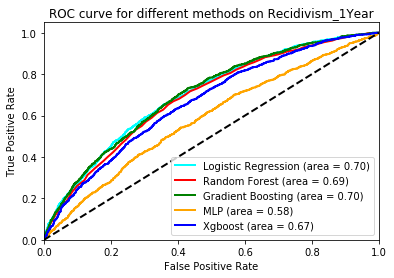

In [18]:
from sklearn.linear_model import LinearRegression,LogisticRegression

X_train1,X_test1,y_train1,y_test1=train_test_split(raw_train.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_train['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

SGD=GradientBoostingClassifier()
params_SGD={'n_estimators':[150],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(SGD,param_grid=params_SGD,cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe=Pipeline([('scaler',StandardScaler()),('mlp',MLPClassifier(max_iter=500,hidden_layer_sizes=[50,50,20],random_state=8,alpha=0.001))])
pipe.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0)))
print('MLP train score:',
      pipe.score(X_train1.fillna(0),y_train1),'\n test score:',pipe.score(X_test1.fillna(0),y_test1.fillna(0)),'\n MLP  train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0))))

XGB=XGBClassifier()
params_XGB={'n_estimators':[100,200,300],'max_depth':[6,8,10]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

### Feature selection and processing

#### Fill the missing value and remove outliers

In [9]:
raw_train=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
raw_train=raw_train.drop(columns=['Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year',
       'Employment_Exempt'])
raw_train
raw_train.columns

Index(['ID', 'Gender', 'Race', 'Age_at_Release', 'Residence_PUMA',
       'Gang_Affiliated', 'Supervision_Risk_Score_First',
       'Supervision_Level_First', 'Education_Level', 'Dependents',
       'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony',
       'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
     

In [43]:
for column in raw_train.columns:
    print (column,':',raw_train[column].isnull().sum())

ID : 0
Gender : 0
Race : 0
Age_at_Release : 0
Residence_PUMA : 0
Gang_Affiliated : 2217
Supervision_Risk_Score_First : 330
Supervision_Level_First : 1212
Education_Level : 0
Dependents : 0
Prison_Offense : 2321
Prison_Years : 0
Prior_Arrest_Episodes_Felony : 0
Prior_Arrest_Episodes_Misd : 0
Prior_Arrest_Episodes_Violent : 0
Prior_Arrest_Episodes_Property : 0
Prior_Arrest_Episodes_Drug : 0
Prior_Arrest_Episodes_PPViolationCharges : 0
Prior_Arrest_Episodes_DVCharges : 0
Prior_Arrest_Episodes_GunCharges : 0
Prior_Conviction_Episodes_Felony : 0
Prior_Conviction_Episodes_Misd : 0
Prior_Conviction_Episodes_Viol : 0
Prior_Conviction_Episodes_Prop : 0
Prior_Conviction_Episodes_Drug : 0
Prior_Conviction_Episodes_PPViolationCharges : 0
Prior_Conviction_Episodes_DomesticViolenceCharges : 0
Prior_Conviction_Episodes_GunCharges : 0
Prior_Revocations_Parole : 0
Prior_Revocations_Probation : 0
Condition_MH_SA : 0
Condition_Cog_Ed : 0
Condition_Other : 0
Recidivism_Within_3years : 0
Recidivism_Arrest_

In [29]:
raw_train[raw_train['Prison_Offense']=='Property'].Prison_Years.value_counts()/raw_train[raw_train['Prison_Offense']=='Property'].shape[0]

Less than 1 year             0.340348
1-2 years                    0.334828
Greater than 2 to 3 years    0.180611
More than 3 years            0.144213
Name: Prison_Years, dtype: float64

In [30]:
raw_train[raw_train['Prison_Offense']=='Violent/Non-Sex'].Prison_Years.value_counts()/raw_train[raw_train['Prison_Offense']=='Violent/Non-Sex'].shape[0]

More than 3 years            0.459837
1-2 years                    0.234659
Greater than 2 to 3 years    0.175402
Less than 1 year             0.130103
Name: Prison_Years, dtype: float64

In [31]:
raw_train[raw_train['Prison_Offense']=='Violent/Sex'].Prison_Years.value_counts()/raw_train[raw_train['Prison_Offense']=='Violent/Sex'].shape[0]

More than 3 years            0.567753
Greater than 2 to 3 years    0.209262
1-2 years                    0.161235
Less than 1 year             0.061750
Name: Prison_Years, dtype: float64

In [25]:
raw_train[raw_train['Prison_Offense'].isnull()].Prison_Years.value_counts()

Less than 1 year             911
1-2 years                    760
More than 3 years            353
Greater than 2 to 3 years    297
Name: Prison_Years, dtype: int64

In [20]:
raw_train['Prison_Offense'].value_counts()

Property           5797
Violent/Non-Sex    3797
Drug               3617
Other              1913
Violent/Sex         583
Name: Prison_Offense, dtype: int64

In [6]:

# remove outliers
raw_train=raw_train.drop(index=raw_train[raw_train.Supervision_Risk_Score_First.isnull()].index)
raw_train=raw_train.drop(index=set(raw_train[raw_train.Supervision_Risk_Score_First.isnull()].index) & set(raw_train[raw_train.Prison_Offense .isnull()].index))

# fill in missing value
raw_train['Gang_Affiliated']=raw_train['Gang_Affiliated'].fillna(False)
raw_train['Prison_Offense']=raw_train['Prison_Offense'].fillna('Property')
raw_train['Supervision_Level_First']=raw_train['Supervision_Level_First'].fillna('Standard')
raw_train=raw_train.reindex()

In [131]:
raw_train

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,False,False,False,True,True,False,False,False,False,False
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,True,False,False,False,False,False,True,False,False,True
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,False,False,False,True,True,False,True,False,True,False
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,False,False,True,True,True,False,False,False,False,False
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,False,False,False,True,True,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18023,26756,M,BLACK,23-27,9,False,5.0,Standard,At least some college,1,...,False,False,False,False,False,False,True,True,False,False
18024,26758,M,WHITE,38-42,25,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,False,False,True,False,True,False
18025,26759,M,BLACK,33-37,15,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,False,False,True,False,True,False
18026,26760,F,WHITE,33-37,15,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,False,False,False,False,False,False


 Transform the dtype of age, crime counts etc. to **integer** instead of **category** since the quatitive relationship does matter.

In [19]:
raw_train.dtypes

ID                                                     int64
Gender                                                  int8
Race                                                    int8
Age_at_Release                                          int8
Residence_PUMA                                         int64
Gang_Affiliated                                         int8
Supervision_Risk_Score_First                         float64
Supervision_Level_First                                 int8
Education_Level                                         int8
Dependents                                              int8
Prison_Offense                                          int8
Prison_Years                                            int8
Prior_Arrest_Episodes_Felony                            int8
Prior_Arrest_Episodes_Misd                              int8
Prior_Arrest_Episodes_Violent                           int8
Prior_Arrest_Episodes_Property                          int8
Prior_Arrest_Episodes_Dr

In [5]:
raw_train=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
raw_train=raw_train.drop(columns=['Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year',
       'Employment_Exempt'])
raw_train_dummy=pd.get_dummies(raw_train)

scaler = StandardScaler()
for column in raw_train_dummy.columns:
    if raw_train_dummy[column].dtype == object:
        raw_train_dummy[column]=raw_train[column].astype('category')
        raw_train_dummy[column]=raw_train[column].cat.codes
    elif raw_train_dummy[column].dtype == int:
        raw_train_dummy[column]=scaler.fit_transform(raw_train[column])
raw_train_dummy



,ID,Residence_PUMA,Supervision_Risk_Score_First,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Viol,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,...,Prior_Conviction_Episodes_Misd_2,Prior_Conviction_Episodes_Misd_3,Prior_Conviction_Episodes_Misd_4 or more,Prior_Conviction_Episodes_Prop_0,Prior_Conviction_Episodes_Prop_1,Prior_Conviction_Episodes_Prop_2,Prior_Conviction_Episodes_Prop_3 or more,Prior_Conviction_Episodes_Drug_0,Prior_Conviction_Episodes_Drug_1,Prior_Conviction_Episodes_Drug_2 or more
0,1,16,3.0,False,False,False,False,False,False,False,...,0,1,0,0,0,1,0,0,0,1
1,2,16,6.0,True,False,True,True,True,True,False,...,0,0,1,1,0,0,0,0,0,1
2,3,24,7.0,True,False,True,False,True,False,False,...,1,0,0,0,1,0,0,0,0,1
3,4,16,7.0,False,False,False,False,False,False,False,...,0,0,1,0,0,0,1,0,0,1
4,5,16,4.0,True,False,True,False,False,False,False,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18023,26756,9,5.0,True,False,True,False,True,False,False,...,1,0,0,1,0,0,0,1,0,0
18024,26758,25,5.0,False,False,False,False,False,False,False,...,1,0,0,1,0,0,0,1,0,0
18025,26759,15,5.0,False,False,False,False,False,False,False,...,0,0,0,1,0,0,0,1,0,0
18026,26760,15,5.0,False,False,False,False,False,False,False,...,0,0,0,1,0,0,0,1,0,0


In [33]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_train_dummy.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_train_dummy['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD,cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={'n_estimators':[100,200],'max_depth':[8,10],'reg_alpha':[0.001],'reg_lambda':[10000,1000,500]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

NameError: name 'raw_train_dummy' is not defined

In [41]:
raw_train['Residence_PUMA']

0        16
1        16
2        24
3        16
4        16
         ..
18023     9
18024    25
18025    15
18026    15
18027    12
Name: Residence_PUMA, Length: 18028, dtype: int64

In [10]:

# Change the dtype of the feature from object to intagar
raw_train['Residence_PUMA']=raw_train['Residence_PUMA'].astype('category')
raw_train['Residence_PUMA']=raw_train['Residence_PUMA'].cat.codes
raw_train['Age_at_Release']=raw_train['Age_at_Release'].apply(lambda x: int(x[:2]))
raw_train['Dependents']=raw_train['Dependents'].apply(lambda x: int(x[:1]))
raw_train['Prior_Arrest_Episodes_Felony']=raw_train['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Drug']=raw_train['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Misd']=raw_train['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Violent']=raw_train['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Property']=raw_train['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_PPViolationCharges']=raw_train['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
raw_train['Prior_Conviction_Episodes_Felony']=raw_train['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Misd']=raw_train['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Prop']=raw_train['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Drug']=raw_train['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
#raw_train['Delinquency_Reports']=raw_train['Delinquency_Reports'].apply(lambda x: int(x[:1]))
#raw_train['Program_Attendances']=raw_train['Program_Attendances'].apply(lambda x: int(x[:2]))
#raw_train['Program_UnexcusedAbsences']=raw_train['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
#raw_train['Residence_Changes']=raw_train['Residence_Changes'].apply(lambda x: int(x[:1]))


# scale the columns which are not bool or category
        
scaler = StandardScaler()
scaling_set=[]
for column in raw_train.columns:
    if raw_train[column].dtype == object:
        raw_train[column]=raw_train[column].astype('category')
        raw_train[column]=raw_train[column].cat.codes
    elif raw_train[column].dtype in ['int64','float32','float64'] :
        scaling_set+=[column]
raw_train[scaling_set]=scaler.fit_transform(raw_train[scaling_set].values)

In [48]:
XGB=XGBClassifier(objective='binary:logistic')
params_XGB={'n_estimators':[100],'max_depth':[10],'reg_alpha':[0.001],'reg_lambda':[1000]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))

KeyboardInterrupt: 

Logistic regression train score: 0.7155880358622768 
 test score: 0.7129943502824859 
 Logistic regression train Brier score: 0.18797484482548624 
 test Brier score: 0.18682258971694454 
 AUROC: 0.7023398554627641
Random forest train score: 1.0 
 test score: 0.7123163841807909 
 Random forest  train Brier score: 0.02651804749826383 
 test Brier score: 0.19012846202134365 
 AUROC: 0.6867682734924561
SGD best layer size: {'min_samples_split': 4, 'n_estimators': 150} 
 best train score: 0.7115193278913511 
 test score: 0.7148022598870056 
 SGD  train Brier score: 0.17631517809581543 
 test Brier score: 0.18735015209949557 
 AUROC: 0.6970516623156889
Epoch 1/200


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


291/291 [==============================] - 1s 2ms/step - loss: 0.7550 - accuracy: 0.6113 - val_loss: 0.5825 - val_accuracy: 0.6999
Epoch 2/200
291/291 [==============================] - 0s 1ms/step - loss: 0.6242 - accuracy: 0.6776 - val_loss: 0.5774 - val_accuracy: 0.7032
Epoch 3/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5969 - accuracy: 0.6983 - val_loss: 0.5756 - val_accuracy: 0.7009
Epoch 4/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5897 - accuracy: 0.6980 - val_loss: 0.5753 - val_accuracy: 0.6996
Epoch 5/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5840 - accuracy: 0.7019 - val_loss: 0.5710 - val_accuracy: 0.7029
Epoch 6/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5806 - accuracy: 0.7062 - val_loss: 0.5714 - val_accuracy: 0.7007
Epoch 7/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5750 - accuracy: 0.7056 - val_loss: 0.5692 - val_accuracy: 0.7019
Epoch 8/200

291/291 [==============================] - 0s 1ms/step - loss: 0.5641 - accuracy: 0.7084 - val_loss: 0.5625 - val_accuracy: 0.7132
Epoch 59/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5600 - accuracy: 0.7119 - val_loss: 0.5630 - val_accuracy: 0.7094
Epoch 60/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5619 - accuracy: 0.7095 - val_loss: 0.5625 - val_accuracy: 0.7107
Epoch 61/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5600 - accuracy: 0.7127 - val_loss: 0.5627 - val_accuracy: 0.7102
Epoch 62/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5573 - accuracy: 0.7149 - val_loss: 0.5642 - val_accuracy: 0.7069
Epoch 63/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.7100 - val_loss: 0.5627 - val_accuracy: 0.7089
Epoch 64/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5620 - accuracy: 0.7054 - val_loss: 0.5629 - val_accuracy: 0.7074
Epoch

Epoch 115/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.7078 - val_loss: 0.5622 - val_accuracy: 0.7140
Epoch 116/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5596 - accuracy: 0.7123 - val_loss: 0.5624 - val_accuracy: 0.7115
Epoch 117/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5584 - accuracy: 0.7124 - val_loss: 0.5619 - val_accuracy: 0.7150
Epoch 118/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5573 - accuracy: 0.7146 - val_loss: 0.5623 - val_accuracy: 0.7117
Epoch 119/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5599 - accuracy: 0.7147 - val_loss: 0.5619 - val_accuracy: 0.7112
Epoch 120/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.7128 - val_loss: 0.5616 - val_accuracy: 0.7117
Epoch 121/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5592 - accuracy: 0.7132 - val_loss: 0.5639 - val_ac

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:4

MLP train Brier score: 0.18644684721428384 
 test Brier score: 0.18707975890972148 
 AUROC: 0.7030837032523579
Xgboost best layer size: {'max_depth': 8, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 1000} 
 best train score: 0.7119712882650021 
 test score: 0.7129943502824859 
 Xgboost train Brier score: 0.1719336070286334 
 test Brier score: 0.1867318386264973 
 AUROC: 0.7013473219270125


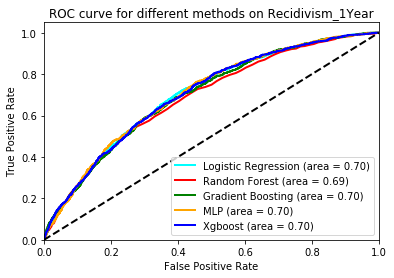

In [137]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_train.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_train['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD,cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={'n_estimators':[100,200],'max_depth':[8,10],'reg_alpha':[0.001],'reg_lambda':[10000,1000,500]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

In [159]:
TabNetClassifier?

In [183]:
len(np.array(X_train1.fillna(0).astype('float32')).tolist()[0])

32

In [186]:
from tabnet import TabNetClassifier, TabNet
Tbnet = TabNetClassifier(feature_columns=list(X_train1.columns),num_classes=2,output_dim =1)
Tbnet.fit(X_train1.fillna(0).astype(float32),y_train1)

[TabNet]: 63 features will be used for decision steps.


ValueError: Items of feature_columns must be a FeatureColumn. Given (type <class 'str'>): Gender.

In [296]:
# Combine different models as a voting system to calculate the weighted probability
def aver_prob(prob_lists):
    n=len(prob_lists)
    return np.sum(np.array(prob_lists),0)/n


brier_score(aver_prob([
                       grid_SGD.best_estimator_.predict_proba(X_test1.fillna(0)),
                       
                       grid_XGB.best_estimator_.predict_proba(X_test1.fillna(0)),
                       
                       ]),y_test1)

0.18787478868895788

### Feature importance
As required by the task

In [139]:
GBDT_importance=pd.DataFrame()
GBDT_importance['Feature']=raw_train.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1).columns
GBDT_importance['importance']=grid_SGD.best_estimator_.feature_importances_
GBDT_importance=GBDT_importance.sort_values(by='importance',ascending=False)
GBDT_importance

,Feature,importance
2,Age_at_Release,0.184230
16,Prior_Arrest_Episodes_PPViolationCharges,0.133858
4,Gang_Affiliated,0.125738
14,Prior_Arrest_Episodes_Property,0.105330
11,Prior_Arrest_Episodes_Felony,0.090084
3,Residence_PUMA,0.042461
5,Supervision_Risk_Score_First,0.040160
12,Prior_Arrest_Episodes_Misd,0.034364
10,Prison_Years,0.028420
9,Prison_Offense,0.020893


                                               feature  importance
5                                      Residence_PUMA        1686
13                       Supervision_Risk_Score_First        1152
4                        Prior_Arrest_Episodes_Felony         921
16                                     Age_at_Release         764
8                                      Prison_Offense         636
22                         Prior_Arrest_Episodes_Drug         636
7                          Prior_Arrest_Episodes_Misd         620
23           Prior_Arrest_Episodes_PPViolationCharges         579
6                      Prior_Conviction_Episodes_Misd         520
1                      Prior_Arrest_Episodes_Property         506
11                                         Dependents         451
3                       Prior_Arrest_Episodes_Violent         449
21                                    Education_Level         444
14                                       Prison_Years         418
26       

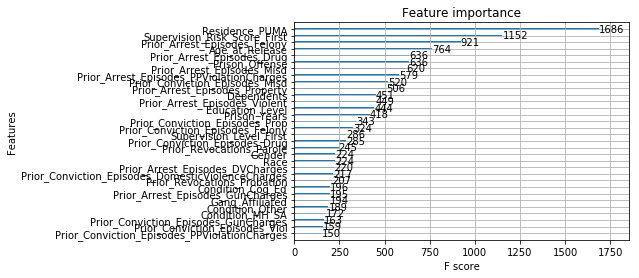

In [140]:
xgb_fea_imp=pd.DataFrame(list(grid_XGB.best_estimator_.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp.csv')

from xgboost import plot_importance
plot_importance(grid_XGB.best_estimator_, )

### Brier as loss function

#### Deep learning

In [6]:
def brier_score(y_prob_raw,y_true):
    y_prob=[prob[1] for prob in y_prob_raw]
    if len(y_prob)!=len(y_true):
        print('Error: two lists must have same length')
        return
    out = 0
    for prob_1,y in zip(y_prob,y_true):
        out+=(prob_1-y)**2
    return out/len(y_prob)

In [31]:
X_train1.astype(float).shape[1]

32

In [11]:
X_train1,X_test1,y_train1,y_test1=train_test_split(raw_train.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_train['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()

In [1]:
from tensorflow.keras.layers import Dense, Input, Add, Lambda, BatchNormalization, Dropout
def custom_loss_function(y_true, y_pred):
    return K.mean((y_true-y_pred[0])**2)
    '''y_prob=[prob[1] for prob in y_pred]
    if len(y_prob)!=len(y_true):
        print('Error: two lists must have same length')
        return
    out = 0
    for prob_1,y in zip(y_prob,y_true):
        out+=(prob_1-y)**2
    return out/len(y_prob)
'''
label = Input(shape = (1, ), name = 'label')
input1 = Input(shape=(X_train1.astype(float).shape[1], ), name='input1')
d1 = Dense(70, activation= 'linear', name='d11')(input1)
d1 =Dropout(0.3,name='dr1')(d1)
d1 = Dense(50, activation= 'relu', name='d12')(d1)
d1 =Dropout(0.3,name='dr2')(d1)
d1 = Dense(50, activation= 'relu', name='d13')(d1)
d1 =Dropout(0.3,name='dr3')(d1)
output1 = Dense(2,activation='softmax', name='output1')(d1)
model1 = Model(inputs = [input1, label], outputs = output1)
model1.add_loss(custom_loss_function(label, output1))

early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
model1.compile(optimizer = 'sgd', metrics=['accuracy'],loss = None)
model1.fit({'input1': X_train1.fillna(0).astype(float), 'label': y_train1.fillna(0)}, None, epochs=100)

NameError: name 'X_train1' is not defined

In [9]:
# loss functino for Keras
def custom_loss_function(y_true, y_pred):
    y_prob=[prob[1] for prob in y_pred]
    if len(y_prob)!=len(y_true):
        print('Error: two lists must have same length')
        return
    out = 0
    for prob_1,y in zip(y_prob,y_true):
        out+=(prob_1-y)**2
    return out/len(y_prob)

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
pipe.add_loss(custom_loss_function(y_train1,))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1.astype('float32'), validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))

NameError: name 'X_train1' is not defined

In [ ]:
pipe.predict_proba(X_test1.fillna(0).astype('float32'))

In [61]:
brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1)

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


0.24997497616794423

#### SGD

In [1]:

def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

def custom_asymmetric_valid(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [8]:
import lightgbm

# default lightgbm model with sklearn api
gbm = lightgbm.LGBMRegressor() 

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores
gbm.set_params(**{'objective': custom_asymmetric_train}, metrics = ["mse", 'mae'])

# fitting model 
gbm.fit(
    X_train1,
    y_train1,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_valid,
    verbose=False,
)

y_pred = gbm.predict(X_valid)


# create dataset for lightgbm
# if you want to re-use data, remember to set free_raw_data=False
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)

# specify your configurations as a dict
params = {
    'objective': 'regression',
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                fobj=custom_asymmetric_train,
                feval=custom_asymmetric_valid,
                valid_sets=lgb_eval)
                
y_pred = gbm.predict(X_valid)

NameError: name 'X_train1' is not defined

#### XGB

In [ ]:
import numpy as np
import xgboost as xgb

dtrain = xgb.DMatrix('/home/kuba/Desktop/agaricus.txt.train')
dtest = xgb.DMatrix('/home/kuba/Desktop/agaricus.txt.test')

def brier(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = 2*(preds-labels)*preds*(1-preds)
    hess = 2*(2*(labels+1)*preds-labels-3*preds*preds)*preds*(1-preds)
    return grad, hess

def evalerror(preds, dtrain):
    preds = 1.0 / (1.0 + np.exp(-preds))
    labels = dtrain.get_label()
    errors = (labels - preds)**2
    return 'brier-error', float(np.sum(errors)) / len(labels)

param = {'max_depth': 2, 'eta': 1, 'silent': 1}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 2

bst = xgb.train(param, dtrain, num_round, watchlist, obj=brier, feval=evalerror)

pred = bst.predict(dtest)
pred.min(), pred.max()
# (-5.809054, 2.2280416)

prob = 1 / (1 + np.exp(-pred))
prob.min(), prob.max()
# (0.0029912924, 0.9027395)

#### Catboost

In [138]:
from catboost import CatBoostClassifier, Pool
CAT_FEATURES = []
catboost_model = CatBoostClassifier(n_estimators=100,
                                   loss_function = 'Logloss',
                                   eval_metric = 'BrierScore',
                                   cat_features = CAT_FEATURES)
catboost_model.fit(X_train1.fillna(0), y_train1, 
                   eval_set = (X_test1.fillna(0), y_test1),
                   use_best_model = True,
                   plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.163411
0:	learn: 0.2309298	test: 0.2312249	best: 0.2312249 (0)	total: 10.2ms	remaining: 1s
1:	learn: 0.2178393	test: 0.2179681	best: 0.2179681 (1)	total: 18.7ms	remaining: 916ms
2:	learn: 0.2080298	test: 0.2082393	best: 0.2082393 (2)	total: 27.4ms	remaining: 886ms
3:	learn: 0.2026522	test: 0.2027600	best: 0.2027600 (3)	total: 36.4ms	remaining: 873ms
4:	learn: 0.1985508	test: 0.1991042	best: 0.1991042 (4)	total: 46.9ms	remaining: 892ms
5:	learn: 0.1952197	test: 0.1959013	best: 0.1959013 (5)	total: 57.5ms	remaining: 900ms
6:	learn: 0.1929349	test: 0.1938049	best: 0.1938049 (6)	total: 68.2ms	remaining: 906ms
7:	learn: 0.1910116	test: 0.1923844	best: 0.1923844 (7)	total: 78.2ms	remaining: 900ms
8:	learn: 0.1899488	test: 0.1912277	best: 0.1912277 (8)	total: 87.5ms	remaining: 885ms
9:	learn: 0.1888647	test: 0.1905036	best: 0.1905036 (9)	total: 97.9ms	remaining: 881ms
10:	learn: 0.1880103	test: 0.1897406	best: 0.1897406 (10)	total: 108ms	remaining: 873ms
11:	learn: 0.18

94:	learn: 0.1572374	test: 0.1882701	best: 0.1854716 (35)	total: 961ms	remaining: 50.6ms
95:	learn: 0.1568839	test: 0.1884481	best: 0.1854716 (35)	total: 972ms	remaining: 40.5ms
96:	learn: 0.1565853	test: 0.1883918	best: 0.1854716 (35)	total: 981ms	remaining: 30.3ms
97:	learn: 0.1562328	test: 0.1883869	best: 0.1854716 (35)	total: 992ms	remaining: 20.2ms
98:	learn: 0.1559949	test: 0.1883951	best: 0.1854716 (35)	total: 1s	remaining: 10.1ms
99:	learn: 0.1556398	test: 0.1883165	best: 0.1854716 (35)	total: 1.01s	remaining: 0us

bestTest = 0.1854715883
bestIteration = 35

Shrink model to first 36 iterations.


In [15]:
catboost_model.predict_proba(X_test1)

array([[0.88569209, 0.11430791],
       [0.75197481, 0.24802519],
       [0.63000019, 0.36999981],
       ...,
       [0.81485596, 0.18514404],
       [0.47359156, 0.52640844],
       [0.57911014, 0.42088986]])

In [30]:
pd.DataFrame({'feature_importance': catboost_model.get_feature_importance(Pool(X_train1)), 
              'feature_names': X_train1.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
2,17.282789,Age_at_Release
4,9.333018,Gang_Affiliated
14,7.505457,Prior_Arrest_Episodes_Property
16,7.309388,Prior_Arrest_Episodes_PPViolationCharges
10,4.552594,Prison_Years
11,4.481257,Prior_Arrest_Episodes_Felony
3,4.254723,Residence_PUMA
7,3.991319,Education_Level
9,3.586114,Prison_Offense
13,3.504396,Prior_Arrest_Episodes_Violent


### PUMA external data

In [32]:
raw_train.Residence_PUMA

0        16
1        16
2        24
3        16
4        16
         ..
18023     9
18024    25
18025    15
18026    15
18027    12
Name: Residence_PUMA, Length: 18028, dtype: int64

In [69]:
Law_enforcement=pd.read_excel(r'.\data\table_80_full_time_law_enforcement_employees_georgia_by_metropolitan_and_nonmetropolitan_counties_2012.xls')
crime_rates=pd.read_excel(r'.\data\georgia crime rates.xlsx',header=1)
crime_rates=crime_rates.groupby(by='County').sum().iloc[11:,:]
crime_len=pd.merge(Law_enforcement,crime_rates,left_on='County',right_on='County')
crime_len=crime_len.drop(columns=crime_len.columns[crime_len.isnull().any()])
crime_len

,County,Total law\nenforcement\nemployees,Total\nofficers,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft
0,Barrow,190,129,61,2,33,20,302,547,1551,145
1,Bartow,234,197,37,0,13,32,329,806,2263,264
2,Bibb,361,296,65,19,67,296,416,2500,6297,715
3,Brantley,43,19,24,0,1,7,16,191,243,10
4,Brooks,51,22,29,2,2,9,45,114,291,31
...,...,...,...,...,...,...,...,...,...,...,...
120,Webster,6,5,1,0,0,1,0,8,7,3
121,White,73,40,33,0,3,4,35,153,328,15
122,Wilcox,16,10,6,0,5,2,16,72,93,10
123,Wilkes,27,14,13,0,0,0,32,29,106,11


In [70]:
crime_len=crime_len.set_index(keys='County')

In [71]:
crime_len['PUMA']=None
crime_len.loc['Barrow','PUMA']=3800
crime_len.loc['Bartow','PUMA']=2900
crime_len.loc['Bibb','PUMA']=1700
crime_len.loc['Bryan','PUMA']=200
crime_len.loc['Carroll','PUMA']=2300
crime_len.loc['Catoosa','PUMA']=2600
crime_len.loc['Chatham','PUMA']=401
crime_len.loc['Chattahoochee','PUMA']=1700
crime_len.loc['Cherokee','PUMA']=3101
crime_len.loc['Clarke','PUMA']=3600
crime_len.loc['Clayton','PUMA']=5001
crime_len.loc['Cobb','PUMA']=3001
crime_len.loc['Columbia','PUMA']=4100
crime_len.loc['Coweta','PUMA']=2100
crime_len.loc['Dade','PUMA']=2600
crime_len.loc['Dougherty','PUMA']=900
crime_len.loc['Effingham','PUMA']=300
crime_len.loc['Floyd','PUMA']=2500
crime_len.loc['Forsyth','PUMA']=3300
crime_len.loc['Fulton','PUMA']=4600
crime_len.loc['Glynn','PUMA']=100
crime_len.loc['Hall','PUMA']=3400
crime_len.loc['Haralson','PUMA']=2500
crime_len.loc['Heard','PUMA']=2200
crime_len.loc['Houston','PUMA']=1500
crime_len.loc['Long','PUMA']=200
crime_len.loc['Lowndes','PUMA']=600
crime_len.loc['McIntosh','PUMA']=100
crime_len.loc['Morgan','PUMA']=3900
crime_len.loc['Newton','PUMA']=4300
crime_len.loc['Paulding','PUMA']=4500
crime_len.loc['Pulaski','PUMA']=1500
crime_len.loc['Rockdale','PUMA']=4300
crime_len.loc['Walker','PUMA']=2600
crime_len.loc['Walton','PUMA']=3900
crime_len.loc['Whitfield','PUMA']=2700
crime_len.loc['Worth','PUMA']=800
crime_len.loc['Bulloch','PUMA']=300
crime_len.loc['Camden','PUMA']=100
crime_len.loc['Chattooga','PUMA']=2600
crime_len.loc['Decatur','PUMA']=2002
crime_len.loc['Dooly','PUMA']=2600
crime_len.loc['Jackson','PUMA']=3800
crime_len.loc['Macon','PUMA']=1400
crime_len.loc['Polk','PUMA']=2500
crime_len.loc['Screven','PUMA']=300
crime_len.loc['Thomas','PUMA']=800
crime_len.loc['Troup','PUMA']=2200
crime_len.loc['Union','PUMA']=1004

In [72]:
crime_len

,Total law\nenforcement\nemployees,Total\nofficers,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft,PUMA
County,,,,,,,,,,,
Barrow,190,129,61,2,33,20,302,547,1551,145,3800
Bartow,234,197,37,0,13,32,329,806,2263,264,2900
Bibb,361,296,65,19,67,296,416,2500,6297,715,1700
Brantley,43,19,24,0,1,7,16,191,243,10,None
Brooks,51,22,29,2,2,9,45,114,291,31,None
...,...,...,...,...,...,...,...,...,...,...,...
Webster,6,5,1,0,0,1,0,8,7,3,None
White,73,40,33,0,3,4,35,153,328,15,None
Wilcox,16,10,6,0,5,2,16,72,93,10,None


In [73]:
crime_len.drop(crime_len.PUMA.isnull)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [59]:
crime_len.PUMA.isnull()

0           True
1           True
2           True
3           True
4           True
           ...  
Polk       False
Screven    False
Thomas     False
Troup      False
Union      False
Name: PUMA, Length: 174, dtype: bool

In [75]:
crime_len.PUMA.isnull()

County
Barrow       False
Bartow       False
Bibb         False
Brantley      True
Brooks        True
             ...  
Webster       True
White         True
Wilcox        True
Wilkes        True
Wilkinson     True
Name: PUMA, Length: 125, dtype: bool

In [79]:
crime_len.drop(index=crime_len[crime_len.PUMA.isnull()].index)

,Total law\nenforcement\nemployees,Total\nofficers,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft,PUMA
County,,,,,,,,,,,
Barrow,190,129,61,2,33,20,302,547,1551,145,3800
Bartow,234,197,37,0,13,32,329,806,2263,264,2900
Bibb,361,296,65,19,67,296,416,2500,6297,715,1700
Bryan,66,45,21,1,2,8,18,110,352,15,200
Carroll,186,105,81,5,46,51,210,841,2655,212,2300
Catoosa,141,69,72,0,7,11,101,270,1469,148,2600
Chatham,514,450,64,33,57,478,517,2532,6850,810,401
Chattahoochee,13,7,6,0,0,0,0,23,3,1,1700
Cherokee,388,327,61,3,17,34,99,627,2212,161,3101


In [33]:
data_PUMA=pd.read_csv(r'.\data\psam_h13.csv')
data_PUMA['Code']=None
data_PUMA

C:\Users\myjr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80,Code
0,H,2015000000065,5,4200,3,13,1079106,1080470,16,1,...,29,14,15,19,19,26,13,23,22,None
1,H,2015000000075,5,800,3,13,1079106,1080470,2,4,...,3,3,6,6,2,4,3,3,1,None
2,H,2015000000077,5,3003,3,13,1079106,1080470,11,2,...,11,10,3,11,15,3,3,16,3,None
3,H,2015000000132,5,1001,3,13,1079106,1080470,36,1,...,54,11,38,56,61,65,32,10,11,None
4,H,2015000000140,5,2002,3,13,1079106,1080470,25,2,...,42,24,8,7,25,39,7,42,24,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236768,H,2019HU1412250,5,3300,3,13,1000000,1010145,10,1,...,2,4,18,17,12,9,11,10,17,None
236769,H,2019HU1412307,5,3001,3,13,1000000,1010145,19,3,...,14,28,16,19,22,37,36,29,12,None
236770,H,2019HU1412334,5,200,3,13,1000000,1010145,10,3,...,4,4,10,13,11,9,17,19,3,None
236771,H,2019HU1412347,5,4006,3,13,1000000,1010145,20,3,...,6,17,5,5,17,6,35,23,23,None


In [34]:
data_PUMA['PUMA']=data_PUMA['PUMA'].astype(str)
PUMA_code_map={'1003':1,'4400':1,'1008':2,'4300':2,'1200':3, '1300':3,'1400':4,'1500':4,'1600':4,'1700':5,'1800':5,
              '2001':6,'2002':6,'2003':6,'4005':6,'100':7,'200':7,'500':7,'4000':8,'4100':8,'4200':8,'5001':9,'6001':9,'6002':9,
              '2400':10,'5002':10,'1001':11,'3004':11,'4600':11,'1002':12, '1005':12, '3300':12, '3400':12, '4001':12, '4002':12,
              '4006':12,'3101':13,'3102':13,'1900':14, '3900':14, '4003':14, '4004':14,'3001':15, '3002':15, '3003':15, '3005':15,
              '2500':16, '4500':16,'2800':17, '2900':17, '3200':17, '3500':17,'600':18, '700':18, '800':18,'900':19, '1100':19,
              '300':20, '401':20, '402':20, '1004':21, '2100':21 ,'2200':22, '2300':22, '1006':23, '1007':23, '2004':23,'2600':24, 
              '2700':24,'3600':25, '3700':25, '3800':25}
data_PUMA['Code']=data_PUMA['PUMA'].map(PUMA_code_map)
data_PUMA['Code']

0          8
1         18
2         15
3         11
4          6
          ..
236768    12
236769    15
236770     7
236771    12
236772     4
Name: Code, Length: 236773, dtype: int64

In [35]:
data_PUMA

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80,Code
0,H,2015000000065,5,4200,3,13,1079106,1080470,16,1,...,29,14,15,19,19,26,13,23,22,8
1,H,2015000000075,5,800,3,13,1079106,1080470,2,4,...,3,3,6,6,2,4,3,3,1,18
2,H,2015000000077,5,3003,3,13,1079106,1080470,11,2,...,11,10,3,11,15,3,3,16,3,15
3,H,2015000000132,5,1001,3,13,1079106,1080470,36,1,...,54,11,38,56,61,65,32,10,11,11
4,H,2015000000140,5,2002,3,13,1079106,1080470,25,2,...,42,24,8,7,25,39,7,42,24,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236768,H,2019HU1412250,5,3300,3,13,1000000,1010145,10,1,...,2,4,18,17,12,9,11,10,17,12
236769,H,2019HU1412307,5,3001,3,13,1000000,1010145,19,3,...,14,28,16,19,22,37,36,29,12,15
236770,H,2019HU1412334,5,200,3,13,1000000,1010145,10,3,...,4,4,10,13,11,9,17,19,3,7
236771,H,2019HU1412347,5,4006,3,13,1000000,1010145,20,3,...,6,17,5,5,17,6,35,23,23,12


In [40]:
data_PUMA.columns[:60]

Index(['RT', 'SERIALNO', 'DIVISION', 'PUMA', 'REGION', 'ST', 'ADJHSG',
       'ADJINC', 'WGTP', 'NP', 'TYPE', 'ACCESS', 'ACR', 'AGS', 'BATH', 'BDSP',
       'BLD', 'BUS', 'BROADBND', 'COMPOTHX', 'CONP', 'DIALUP', 'ELEFP', 'ELEP',
       'FS', 'FULFP', 'FULP', 'GASFP', 'GASP', 'HFL', 'HISPEED', 'HOTWAT',
       'INSP', 'LAPTOP', 'MHP', 'MRGI', 'MRGP', 'MRGT', 'MRGX', 'OTHSVCEX',
       'REFR', 'RMSP', 'RNTM', 'RNTP', 'RWAT', 'RWATPR', 'SATELLITE', 'SINK',
       'SMARTPHONE', 'SMP', 'STOV', 'TABLET', 'TEL', 'TEN', 'TOIL', 'VACS',
       'VALP', 'VEH', 'WATFP', 'WATP'],
      dtype='object')

In [37]:
PUMA_group=data_PUMA.groupby(by='Code',as_index=False).mean()
PUMA_group=PUMA_group.iloc[:,:55].drop(columns=['DIVISION', 'REGION', 'ST', 'ADJHSG', 'ADJINC'])
PUMA_group

,Code,WGTP,NP,TYPE,ACCESS,ACR,AGS,BATH,BDSP,BLD,...,SINK,SMARTPHONE,SMP,STOV,TABLET,TEL,TEN,TOIL,VACS,VALP
0,1,23.870318,2.095692,1.061052,1.308561,1.249925,1.088591,1.012256,2.924194,3.163187,...,1.012029,1.189807,378.414097,1.018157,1.379864,1.019332,1.975395,7.374262,4.508274,185326.445951
1,2,22.864930,2.282520,1.098670,1.266003,1.330750,1.069044,1.006789,3.182308,2.551917,...,1.006789,1.182916,321.379538,1.012780,1.380246,1.016744,1.784231,7.365016,5.179310,176850.332082
2,3,11.943916,1.785361,1.224428,1.626199,1.585050,1.194942,1.016669,2.814117,1.959076,...,1.016209,1.359002,370.595745,1.041269,1.554947,1.033434,2.069471,7.365214,5.918630,115399.790914
3,4,17.702348,1.884028,1.195914,1.416252,1.407047,1.083582,1.012465,2.856093,2.541581,...,1.012558,1.253412,379.877996,1.036372,1.445456,1.020950,1.982542,7.428837,5.411085,158984.426355
4,5,14.434274,1.840685,1.213556,1.493060,1.426474,1.138318,1.011822,2.791735,2.681332,...,1.011513,1.280935,354.948052,1.033717,1.472773,1.027524,2.108672,7.385999,5.004619,154943.976475
5,6,19.205154,2.197948,1.126992,1.213700,1.132255,1.080948,1.002774,2.980584,3.263591,...,1.002959,1.144028,369.319209,1.009893,1.339286,1.016003,1.884563,7.414848,4.452465,265649.457637
6,7,17.421113,1.989541,1.156001,1.419388,1.389359,1.127991,1.010512,2.922470,2.257758,...,1.010108,1.237318,377.887043,1.022743,1.438962,1.021890,1.968728,7.448600,5.165210,175463.990826
7,8,16.731101,1.902182,1.169552,1.468153,1.397227,1.137102,1.011897,2.937494,2.380434,...,1.010799,1.272843,390.640244,1.030566,1.466146,1.022499,1.963241,7.423172,5.174658,160470.663303
8,9,24.400554,2.439304,1.069593,1.212450,1.319792,1.078037,1.002317,3.270908,2.484095,...,1.002949,1.160833,332.980392,1.009690,1.358662,1.017723,1.765618,7.436486,3.836910,184507.419547
9,10,20.250525,2.343637,1.087579,1.254699,1.372279,1.061728,1.004058,3.156250,2.876623,...,1.003653,1.169799,382.392857,1.010146,1.362281,1.019011,1.892417,7.401989,3.478261,239116.872820


In [38]:
PUMA_group.columns

Index(['Code', 'WGTP', 'NP', 'TYPE', 'ACCESS', 'ACR', 'AGS', 'BATH', 'BDSP',
       'BLD', 'BUS', 'BROADBND', 'COMPOTHX', 'CONP', 'DIALUP', 'ELEFP', 'ELEP',
       'FS', 'FULFP', 'FULP', 'GASFP', 'GASP', 'HFL', 'HISPEED', 'HOTWAT',
       'INSP', 'LAPTOP', 'MHP', 'MRGI', 'MRGP', 'MRGT', 'MRGX', 'OTHSVCEX',
       'REFR', 'RMSP', 'RNTM', 'RNTP', 'RWAT', 'RWATPR', 'SATELLITE', 'SINK',
       'SMARTPHONE', 'SMP', 'STOV', 'TABLET', 'TEL', 'TEN', 'TOIL', 'VACS',
       'VALP'],
      dtype='object')

In [279]:
raw_extend=pd.merge(raw_train,PUMA_group,left_on='Residence_PUMA',right_on='Code')
raw_extend

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,SINK,SMARTPHONE,SMP,STOV,TABLET,TEL,TEN,TOIL,VACS,VALP
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,1.010271,1.213102,360.394265,1.023198,1.389495,1.023343,1.825113,7.479901,5.253731,179324.653390
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,1.010271,1.213102,360.394265,1.023198,1.389495,1.023343,1.825113,7.479901,5.253731,179324.653390
2,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,1.010271,1.213102,360.394265,1.023198,1.389495,1.023343,1.825113,7.479901,5.253731,179324.653390
3,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,1.010271,1.213102,360.394265,1.023198,1.389495,1.023343,1.825113,7.479901,5.253731,179324.653390
4,10,M,BLACK,43-47,16,False,5.0,Standard,High School Diploma,3 or more,...,1.010271,1.213102,360.394265,1.023198,1.389495,1.023343,1.825113,7.479901,5.253731,179324.653390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17693,26652,M,BLACK,23-27,7,False,8.0,High,High School Diploma,1,...,1.010108,1.237318,377.887043,1.022743,1.438962,1.021890,1.968728,7.448600,5.165210,175463.990826
17694,26676,M,WHITE,28-32,7,False,5.0,Standard,At least some college,3 or more,...,1.010108,1.237318,377.887043,1.022743,1.438962,1.021890,1.968728,7.448600,5.165210,175463.990826
17695,26723,M,WHITE,38-42,7,False,1.0,Standard,High School Diploma,2,...,1.010108,1.237318,377.887043,1.022743,1.438962,1.021890,1.968728,7.448600,5.165210,175463.990826
17696,26731,M,WHITE,43-47,7,False,3.0,Standard,High School Diploma,2,...,1.010108,1.237318,377.887043,1.022743,1.438962,1.021890,1.968728,7.448600,5.165210,175463.990826


In [280]:
# Change the dtype of the feature from object to intagar
raw_extend['Residence_PUMA']=raw_extend['Residence_PUMA'].astype('category')
raw_extend['Residence_PUMA']=raw_extend['Residence_PUMA'].cat.codes
raw_extend['Age_at_Release']=raw_extend['Age_at_Release'].apply(lambda x: int(x[:2]))
raw_extend['Dependents']=raw_extend['Dependents'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Arrest_Episodes_Felony']=raw_extend['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Drug']=raw_extend['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Misd']=raw_extend['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Violent']=raw_extend['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Property']=raw_extend['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_PPViolationCharges']=raw_extend['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Conviction_Episodes_Felony']=raw_extend['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Misd']=raw_extend['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Prop']=raw_extend['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Drug']=raw_extend['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
#raw_extend['Delinquency_Reports']=raw_extend['Delinquency_Reports'].apply(lambda x: int(x[:1]))
#raw_extend['Program_Attendances']=raw_extend['Program_Attendances'].apply(lambda x: int(x[:2]))
#raw_extend['Program_UnexcusedAbsences']=raw_extend['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
#raw_extend['Residence_Changes']=raw_extend['Residence_Changes'].apply(lambda x: int(x[:1]))


#        
scaler = StandardScaler()
scaling_set=[]
for column in raw_extend.columns:
    if raw_extend[column].dtype == object:
        raw_extend[column]=raw_extend[column].astype('category')
        raw_extend[column]=raw_extend[column].cat.codes
    elif raw_extend[column].dtype in ['int64','float32','float64'] :
        scaling_set+=[column]
raw_extend[scaling_set]=scaler.fit_transform(raw_extend[scaling_set].values)

In [282]:
raw_extend

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,SINK,SMARTPHONE,SMP,STOV,TABLET,TEL,TEN,TOIL,VACS,VALP
0,-1.735857,1,0,1.102034,15,False,-1.286229,2,0,1.257199,...,0.363575,-0.140839,-0.352894,0.148642,-0.333496,0.453769,-0.770094,1.315212,0.582983,-0.393221
1,-1.735727,1,0,0.041382,15,False,-0.027176,1,2,-0.389661,...,0.363575,-0.140839,-0.352894,0.148642,-0.333496,0.453769,-0.770094,1.315212,0.582983,-0.393221
2,-1.735468,1,1,0.571708,15,False,0.392508,0,2,-0.389661,...,0.363575,-0.140839,-0.352894,0.148642,-0.333496,0.453769,-0.770094,1.315212,0.582983,-0.393221
3,-1.735338,1,1,0.041382,15,False,-0.866544,1,2,1.257199,...,0.363575,-0.140839,-0.352894,0.148642,-0.333496,0.453769,-0.770094,1.315212,0.582983,-0.393221
4,-1.734690,1,0,1.102034,15,False,-0.446860,2,1,1.257199,...,0.363575,-0.140839,-0.352894,0.148642,-0.333496,0.453769,-0.770094,1.315212,0.582983,-0.393221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17693,1.718713,1,0,-1.019270,6,False,0.812193,0,1,-0.389661,...,0.322186,0.234087,0.038168,0.100833,0.363186,0.158311,0.383221,0.473525,0.413639,-0.441790
17694,1.721824,1,1,-0.488944,6,False,-0.446860,2,0,1.257199,...,0.322186,0.234087,0.038168,0.100833,0.363186,0.158311,0.383221,0.473525,0.413639,-0.441790
17695,1.727916,1,1,0.571708,6,False,-2.125597,2,1,0.433769,...,0.322186,0.234087,0.038168,0.100833,0.363186,0.158311,0.383221,0.473525,0.413639,-0.441790
17696,1.728953,1,1,1.102034,6,False,-1.286229,2,1,0.433769,...,0.322186,0.234087,0.038168,0.100833,0.363186,0.158311,0.383221,0.473525,0.413639,-0.441790


Logistic regression train score: 0.7149853085210578 
 test score: 0.7154802259887005 
 Logistic regression train Brier score: 0.18712439537157197 
 test Brier score: 0.18788013659066147 
 AUROC: 0.6978058435917205
Random forest train score: 1.0 
 test score: 0.7082485875706215 
 Random forest  train Brier score: 0.026924252241393082 
 test Brier score: 0.19328889893283224 
 AUROC: 0.6730121351419758
SGD best layer size: {'min_samples_split': 2, 'n_estimators': 150} 
 best train score: 0.7132522144236368 
 test score: 0.7141242937853107 
 SGD  train Brier score: 0.17481620363700104 
 test Brier score: 0.18823350475677422 
 AUROC: 0.6981644840414771
Epoch 1/200


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


291/291 [==============================] - 1s 2ms/step - loss: 0.7433 - accuracy: 0.6002 - val_loss: 0.5950 - val_accuracy: 0.7029
Epoch 2/200
291/291 [==============================] - 0s 1ms/step - loss: 0.6248 - accuracy: 0.6814 - val_loss: 0.5903 - val_accuracy: 0.7024
Epoch 3/200
291/291 [==============================] - 0s 1ms/step - loss: 0.6045 - accuracy: 0.6962 - val_loss: 0.5898 - val_accuracy: 0.7017
Epoch 4/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5951 - accuracy: 0.7006 - val_loss: 0.5875 - val_accuracy: 0.7019
Epoch 5/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5904 - accuracy: 0.7009 - val_loss: 0.5848 - val_accuracy: 0.7022
Epoch 6/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5890 - accuracy: 0.7028 - val_loss: 0.5828 - val_accuracy: 0.7027
Epoch 7/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5883 - accuracy: 0.7038 - val_loss: 0.5812 - val_accuracy: 0.7012
Epoch 8/200

291/291 [==============================] - 0s 1ms/step - loss: 0.5632 - accuracy: 0.7079 - val_loss: 0.5630 - val_accuracy: 0.7107
Epoch 59/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5616 - accuracy: 0.7115 - val_loss: 0.5629 - val_accuracy: 0.7082
Epoch 60/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5635 - accuracy: 0.7094 - val_loss: 0.5627 - val_accuracy: 0.7094
Epoch 61/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5628 - accuracy: 0.7132 - val_loss: 0.5627 - val_accuracy: 0.7077
Epoch 62/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5603 - accuracy: 0.7145 - val_loss: 0.5631 - val_accuracy: 0.7082
Epoch 63/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5599 - accuracy: 0.7161 - val_loss: 0.5624 - val_accuracy: 0.7102
Epoch 64/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5646 - accuracy: 0.7085 - val_loss: 0.5623 - val_accuracy: 0.7109
Epoch

Epoch 115/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5567 - accuracy: 0.7118 - val_loss: 0.5624 - val_accuracy: 0.7102
Epoch 116/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5586 - accuracy: 0.7124 - val_loss: 0.5623 - val_accuracy: 0.7107
Epoch 117/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5612 - accuracy: 0.7078 - val_loss: 0.5623 - val_accuracy: 0.7115
Epoch 118/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5580 - accuracy: 0.7143 - val_loss: 0.5622 - val_accuracy: 0.7109
Epoch 119/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5601 - accuracy: 0.7111 - val_loss: 0.5629 - val_accuracy: 0.7107
Epoch 120/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5602 - accuracy: 0.7138 - val_loss: 0.5624 - val_accuracy: 0.7087
Epoch 121/200
291/291 [==============================] - 0s 1ms/step - loss: 0.5586 - accuracy: 0.7112 - val_loss: 0.5619 - val_ac

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:4

MLP train Brier score: 0.18671375162204956 
 test Brier score: 0.1880298246794224 
 AUROC: 0.699798276962286
Xgboost best layer size: {'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 1000} 
 best train score: 0.7166423343992535 
 test score: 0.7123163841807909 
 Xgboost train Brier score: 0.16641309088216052 
 test Brier score: 0.18844684055626504 
 AUROC: 0.6971445086479255


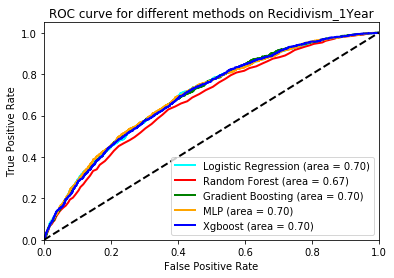

In [283]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend['Recidivism_Arrest_Year1'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD,cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={'n_estimators':[100,200],'max_depth':[8,10],'reg_alpha':[0.001],'reg_lambda':[10000,1000,500]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

In [284]:
from catboost import CatBoostClassifier, Pool
CAT_FEATURES = []
catboost_model = CatBoostClassifier(n_estimators=100,
                                   loss_function = 'Logloss',
                                   eval_metric = 'BrierScore',
                                   cat_features = CAT_FEATURES)
catboost_model.fit(X_train1.fillna(0), y_train1, 
                   eval_set = (X_test1.fillna(0), y_test1),
                   use_best_model = True,
                   plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.163411
0:	learn: 0.2314490	test: 0.2324961	best: 0.2324961 (0)	total: 13ms	remaining: 1.28s
1:	learn: 0.2193812	test: 0.2208914	best: 0.2208914 (1)	total: 23.6ms	remaining: 1.15s
2:	learn: 0.2109408	test: 0.2122175	best: 0.2122175 (2)	total: 34.3ms	remaining: 1.11s
3:	learn: 0.2044549	test: 0.2062792	best: 0.2062792 (3)	total: 46.9ms	remaining: 1.13s
4:	learn: 0.1996009	test: 0.2017915	best: 0.2017915 (4)	total: 59.7ms	remaining: 1.14s
5:	learn: 0.1966706	test: 0.1990941	best: 0.1990941 (5)	total: 71.9ms	remaining: 1.13s
6:	learn: 0.1941800	test: 0.1968082	best: 0.1968082 (6)	total: 84.6ms	remaining: 1.12s
7:	learn: 0.1927204	test: 0.1952194	best: 0.1952194 (7)	total: 94ms	remaining: 1.08s
8:	learn: 0.1913075	test: 0.1941392	best: 0.1941392 (8)	total: 104ms	remaining: 1.05s
9:	learn: 0.1901962	test: 0.1932820	best: 0.1932820 (9)	total: 115ms	remaining: 1.04s
10:	learn: 0.1892191	test: 0.1927414	best: 0.1927414 (10)	total: 128ms	remaining: 1.03s
11:	learn: 0.18808

95:	learn: 0.1568617	test: 0.1895936	best: 0.1878162 (57)	total: 1.17s	remaining: 48.7ms
96:	learn: 0.1564084	test: 0.1896642	best: 0.1878162 (57)	total: 1.18s	remaining: 36.5ms
97:	learn: 0.1559300	test: 0.1895954	best: 0.1878162 (57)	total: 1.19s	remaining: 24.4ms
98:	learn: 0.1556768	test: 0.1896216	best: 0.1878162 (57)	total: 1.21s	remaining: 12.2ms
99:	learn: 0.1553837	test: 0.1895739	best: 0.1878162 (57)	total: 1.22s	remaining: 0us

bestTest = 0.187816163
bestIteration = 57

Shrink model to first 58 iterations.


In [287]:
GBDT_importance=pd.DataFrame()
GBDT_importance['Feature']=raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1).columns
GBDT_importance['importance']=grid_SGD.best_estimator_.feature_importances_
GBDT_importance=GBDT_importance.sort_values(by='importance',ascending=False)
GBDT_importance

,Feature,importance
2,Age_at_Release,0.178132
16,Prior_Arrest_Episodes_PPViolationCharges,0.127627
4,Gang_Affiliated,0.123990
14,Prior_Arrest_Episodes_Property,0.088303
11,Prior_Arrest_Episodes_Felony,0.071576
...,...,...
68,RNTP,0.000000
58,LAPTOP,0.000000
40,BDSP,0.000000
52,GASFP,0.000000


In [291]:
GBDT_importance[GBDT_importance['importance']==0].Feature

70    RWATPR
56    HOTWAT
68      RNTP
58    LAPTOP
40      BDSP
52     GASFP
45      CONP
Name: Feature, dtype: object

                          feature  importance
12  Supervision_Risk_Score_First        1605
5   Prior_Arrest_Episodes_Felony        1298
6                 Age_at_Release        1095
24    Prior_Arrest_Episodes_Misd         986
21    Prior_Arrest_Episodes_Drug         970
..                           ...         ...
73                          VALP          11
54                          STOV          10
77                        LAPTOP           3
78                        TABLET           3
76                    SMARTPHONE           2

[79 rows x 2 columns]


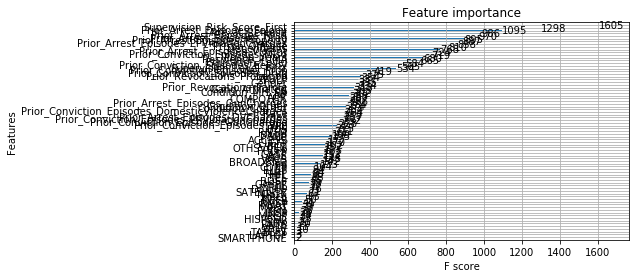

In [297]:
xgb_fea_imp=pd.DataFrame(list(grid_XGB.best_estimator_.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp.csv')

from xgboost import plot_importance
plot_importance(grid_XGB.best_estimator_, )

### Intermediate Label prediction

In [8]:
# Keep the 'Percent_Days_Employed', 'Jobs_Per_Year' as intermediate features
raw_train=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
raw_train=raw_train.drop(columns=['Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive','Employment_Exempt'])
# remove outliers
raw_train=raw_train.drop(index=raw_train[raw_train.Supervision_Risk_Score_First.isnull()].index)
raw_train=raw_train.drop(index=raw_train[raw_train.Percent_Days_Employed.isnull()].index)
raw_train=raw_train.drop(index=raw_train[raw_train.Jobs_Per_Year.isnull()].index)
raw_train=raw_train.drop(index=set(raw_train[raw_train.Supervision_Risk_Score_First.isnull()].index) & set(raw_train[raw_train.Prison_Offense .isnull()].index))

# fill in missing value
raw_train['Gang_Affiliated']=raw_train['Gang_Affiliated'].fillna(False)
raw_train['Prison_Offense']=raw_train['Prison_Offense'].fillna('Property')
raw_train['Supervision_Level_First']=raw_train['Supervision_Level_First'].fillna('Standard')
raw_train=raw_train.reindex()
raw_train

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other,Percent_Days_Employed,Jobs_Per_Year,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,False,True,True,False,0.488562,0.447610,False,False,False,False
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,False,False,False,False,0.425234,2.000000,True,False,False,True
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,False,True,True,False,0.000000,0.000000,True,False,True,False
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,True,True,True,False,1.000000,0.718996,False,False,False,False
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,False,True,True,True,0.203562,0.929389,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18023,26756,M,BLACK,23-27,9,False,5.0,Standard,At least some college,1,...,False,False,False,False,0.189507,0.572044,True,True,False,False
18024,26758,M,WHITE,38-42,25,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,0.757098,0.576104,True,False,True,False
18025,26759,M,BLACK,33-37,15,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,0.711138,0.894125,True,False,True,False
18026,26760,F,WHITE,33-37,15,False,5.0,Standard,At least some college,3 or more,...,False,False,False,False,0.000000,0.000000,False,False,False,False


In [9]:

# Change the dtype of the feature from object to intagar
raw_train['Residence_PUMA']=raw_train['Residence_PUMA'].astype('category')
raw_train['Residence_PUMA']=raw_train['Residence_PUMA'].cat.codes
raw_train['Age_at_Release']=raw_train['Age_at_Release'].apply(lambda x: int(x[:2]))
raw_train['Dependents']=raw_train['Dependents'].apply(lambda x: int(x[:1]))
raw_train['Prior_Arrest_Episodes_Felony']=raw_train['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Drug']=raw_train['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Misd']=raw_train['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Violent']=raw_train['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_Property']=raw_train['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
raw_train['Prior_Arrest_Episodes_PPViolationCharges']=raw_train['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
raw_train['Prior_Conviction_Episodes_Felony']=raw_train['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Misd']=raw_train['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Prop']=raw_train['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
raw_train['Prior_Conviction_Episodes_Drug']=raw_train['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
#raw_train['Delinquency_Reports']=raw_train['Delinquency_Reports'].apply(lambda x: int(x[:1]))
#raw_train['Program_Attendances']=raw_train['Program_Attendances'].apply(lambda x: int(x[:2]))
#raw_train['Program_UnexcusedAbsences']=raw_train['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
#raw_train['Residence_Changes']=raw_train['Residence_Changes'].apply(lambda x: int(x[:1]))


# scale the columns which are not bool or category
        
scaler = StandardScaler()
scaling_set=[]
for column in raw_train.columns:
    if raw_train[column].dtype == object:
        raw_train[column]=raw_train[column].astype('category')
        raw_train[column]=raw_train[column].cat.codes
    elif raw_train[column].dtype in ['int64','float32','float64'] :
        scaling_set+=[column]
raw_train[scaling_set]=scaler.fit_transform(raw_train[scaling_set].values)

In [10]:
raw_train.Percent_Days_Employed

0       -0.001831
1       -0.151653
2       -1.157666
3        1.208124
4       -0.676080
           ...   
18023   -0.709333
18024    0.633468
18025    0.524738
18026   -1.157666
18027   -0.863234
Name: Percent_Days_Employed, Length: 17167, dtype: float64

In [11]:
raw_train['Percent_Days_Employed']

0       -0.001831
1       -0.151653
2       -1.157666
3        1.208124
4       -0.676080
           ...   
18023   -0.709333
18024    0.633468
18025    0.524738
18026   -1.157666
18027   -0.863234
Name: Percent_Days_Employed, Length: 17167, dtype: float64

In [14]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_train.drop(['ID','Recidivism_Within_3years',
'Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3','Percent_Days_Employed', 'Jobs_Per_Year'],axis=1),raw_train['Percent_Days_Employed'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


'''logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD,cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))'''

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear', kernel_initializer='normal'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu', kernel_initializer='normal'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(1, kernel_initializer='normal'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'mean_squared_error',optimizer = 'adam', metrics=['mean_squared_error'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1))


XGB=XGBClassifier()
params_XGB={'n_estimators':[100,200],'max_depth':[8,10],'reg_alpha':[0.001],'reg_lambda':[10000,1000,500]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB,cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
#fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      )




C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
282/282 [==============================] - 1s 1ms/step - loss: 0.9905 - mean_squared_error: 0.9905 - val_loss: 0.9615 - val_mean_squared_error: 0.9615
Epoch 2/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9534 - mean_squared_error: 0.9534 - val_loss: 0.9480 - val_mean_squared_error: 0.9480
Epoch 3/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9439 - mean_squared_error: 0.9439 - val_loss: 0.9508 - val_mean_squared_error: 0.9508
Epoch 4/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9448 - mean_squared_error: 0.9448 - val_loss: 0.9524 - val_mean_squared_error: 0.9524
Epoch 5/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9425 - mean_squared_error: 0.9425 - val_loss: 0.9453 - val_mean_squared_error: 0.9453
Epoch 6/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9439 - mean_squared_error: 0.9439 - val_loss: 0.9513 - val_mean_squared_error: 0.9513
Epoch 7/200
282/282 [=

282/282 [==============================] - 0s 1ms/step - loss: 0.9242 - mean_squared_error: 0.9242 - val_loss: 0.9469 - val_mean_squared_error: 0.9469
Epoch 52/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9210 - mean_squared_error: 0.9210 - val_loss: 0.9515 - val_mean_squared_error: 0.9515
Epoch 53/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9221 - mean_squared_error: 0.9221 - val_loss: 0.9520 - val_mean_squared_error: 0.9520
Epoch 54/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9168 - mean_squared_error: 0.9168 - val_loss: 0.9489 - val_mean_squared_error: 0.9489
Epoch 55/200
282/282 [==============================] - 0s 1ms/step - loss: 0.9240 - mean_squared_error: 0.9240 - val_loss: 0.9487 - val_mean_squared_error: 0.9487


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


IndexError: index 1 is out of bounds for axis 0 with size 1

### Bias
FP = 1- | FP_white - FP_black | <br>
Accurate and fair = (1-Brier Score) * FP

In [301]:
raw_extend.Recidivism_Arrest_Year1

0        False
1        False
2        False
3         True
4         True
         ...  
17693     True
17694    False
17695    False
17696    False
17697    False
Name: Recidivism_Arrest_Year1, Length: 17698, dtype: bool

In [302]:
raw_extend

0        15
1        15
2        15
3        15
4        15
         ..
17693     6
17694     6
17695     6
17696     6
17697     6
Name: Residence_PUMA, Length: 17698, dtype: int8